In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CosineSimilarity
from tensorflow.linalg import norm
from tensorflow import reduce_sum

from gw_grb_correlation.Fermi.data_preprocessing import create_dataframe_and_name_column_from_data_files

In [2]:
from gw_grb_correlation.Fermi.util import process_data

# Load data
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')

# List of detectors
detectors = [f"n{i}" for i in range(10)] + ["na", "nb", "b0", "b1"]

# Define input columns
PH_CNT_columns = [f"{detector}_PH_CNT" for detector in detectors]
TRIG_columns = [f"{detector}_TRIG" for detector in detectors]
Orientation_columns = ['QSJ_1', 'QSJ_2', 'QSJ_3', 'QSJ_4']
fermi_data[PH_CNT_columns] = np.array(fermi_data[PH_CNT_columns].values.astype(np.float64)) * np.array(fermi_data[TRIG_columns].values.astype(np.float64))

input_columns = Orientation_columns + TRIG_columns + PH_CNT_columns

X_scaled, X_train_scaled, X_test_scaled, y, y_train, y_test = process_data(fermi_data, input_columns)

In [3]:
from gw_grb_correlation.Fermi.util import cosine_similarity_loss
# Define model with Dropout
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(3, activation=None),  # Output layer, no activation
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=cosine_similarity_loss,
    metrics=[CosineSimilarity(name='cosine_similarity')]
)

C:\Users\colon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - cosine_similarity: -0.0051 - loss: 0.0051 - val_cosine_similarity: 0.0159 - val_loss: -0.0159
Epoch 2/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0357 - loss: -0.0357 - val_cosine_similarity: 0.0262 - val_loss: -0.0262
Epoch 3/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.0173 - loss: -0.0173 - val_cosine_similarity: 0.0370 - val_loss: -0.0370
Epoch 4/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0390 - loss: -0.0390 - val_cosine_similarity: 0.0569 - val_loss: -0.0569
Epoch 5/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0608 - loss: -0.0608 - val_cosine_similarity: 0.0982 - val_loss: -0.0982
Epoch 6/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0905 - loss: -0.0905 - val_cosine_similarity: 0.1075 - val_loss: -0.1075
Epoch 7/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.1083 - loss: -0.1083 - val_cos

Model trained and saved as model_with_orientation.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.9202 - loss: -0.9202 
Test Loss: -0.9138
Cosine Similarity: 0.9138
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean norm of predicted vectors: 0.6401298
Standard deviation of norms: 0.21337941


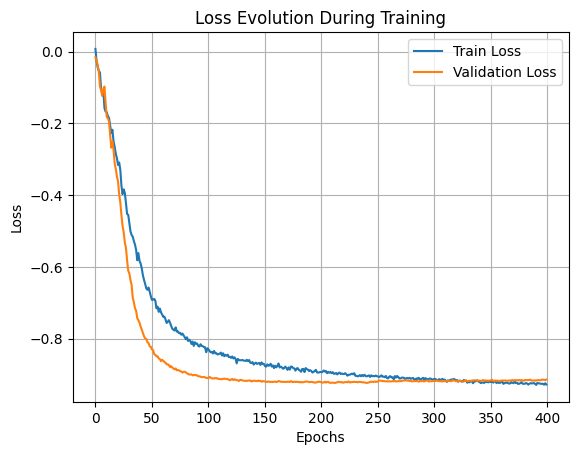

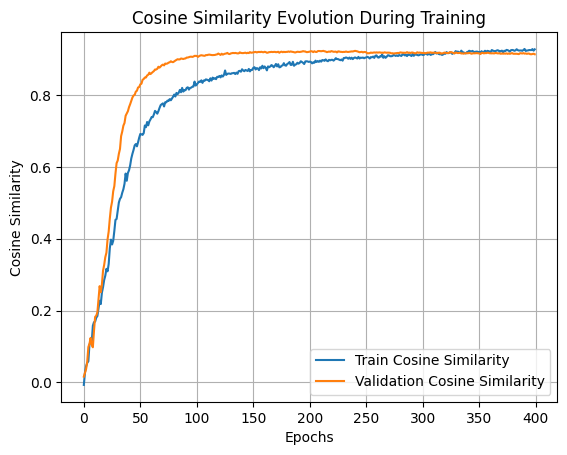

In [4]:
# Train model
history = model.fit(
    X_train_scaled, y_train,
    epochs=400,
    batch_size=16,
    validation_data=(X_test_scaled, y_test)
)

model_path = "model_with_orientation.h5"
# Save the trained model
model.save(model_path)
print(f"Model trained and saved as {model_path}")

from gw_grb_correlation.Fermi.visualization import evaluate_model_and_plot_accurracy
evaluate_model_and_plot_accurracy(model, history, X_test_scaled, y_test)

In [5]:
from gw_grb_correlation.Fermi.util import convert_cartesian_to_spherical
predictions = model.predict(X_scaled)

RA_DEC_predictions = np.array([convert_cartesian_to_spherical(pred) for pred in predictions])
fermi_predict_data = fermi_data.copy()

fermi_predict_data['RA'] = RA_DEC_predictions[:, 0]
fermi_predict_data['DEC'] = RA_DEC_predictions[:, 1]

fermi_predict_data.to_csv("fermi_predict_data.csv", index=False)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [6]:
from gw_grb_correlation.Fermi.util import filtering, duration
# Filter out short GRB data
short_GRB_data = filtering(fermi_predict_data, criteria={'T90': lambda x: x <= 2.1})

# Calculate the duration (difference between max TSTOP and min TSTART) and count the short GRB event number
duration_short_GRB = duration(short_GRB_data)
event_num_short_GRB = len(short_GRB_data)

# Calculate the average occurrence rate (events per unit of time)
average_occurrence_rate = event_num_short_GRB / duration_short_GRB

# Print the results
print(f"Number of events: {event_num_short_GRB}")
print(f"Total duration: {duration_short_GRB} seconds")
print(f"Average occurrence rate: {average_occurrence_rate} events per second")

Number of events: 354
Total duration: 323245732.96269 seconds
Average occurrence rate: 1.0951420665492892e-06 events per second


In [7]:
from gw_grb_correlation.Fermi.util import convert_cartesian_to_spherical
predictions = model.predict(X_scaled)

RA_DEC_predictions = np.array([convert_cartesian_to_spherical(pred) for pred in predictions])
fermi_predict_data = fermi_data.copy()

fermi_predict_data['RA'] = RA_DEC_predictions[:, 0]
fermi_predict_data['DEC'] = RA_DEC_predictions[:, 1]

fermi_predict_data.to_csv("fermi_predict_data.csv", index=False)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [8]:
from gw_grb_correlation.Fermi.util import filtering, duration
# Filter out short GRB data
short_GRB_data = filtering(fermi_predict_data, criteria={'T90': lambda x: x <= 2.1})

# Calculate the duration (difference between max TSTOP and min TSTART) and count the short GRB event number
duration_short_GRB = duration(short_GRB_data)
event_num_short_GRB = len(short_GRB_data)

# Calculate the average occurrence rate (events per unit of time)
average_occurrence_rate = event_num_short_GRB / duration_short_GRB

# Print the results
print(f"Number of events: {event_num_short_GRB}")
print(f"Total duration: {duration_short_GRB} seconds")
print(f"Average occurrence rate: {average_occurrence_rate} events per second")

Number of events: 354
Total duration: 323245732.96269 seconds
Average occurrence rate: 1.0951420665492892e-06 events per second


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,403 (3.83 MB)

 Trainable params: 334,467 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 668,936 (2.55 MB)

In [10]:
# This time, we test model trained without spacecraft orientation data
# Load data again
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')
input_columns = TRIG_columns + PH_CNT_columns # No Spacecraft Orientation

X_scaled, X_train_scaled, X_test_scaled, y, y_train, y_test = process_data(fermi_data, input_columns)

In [12]:
# Define model with Dropout
model_without_orientation = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(3, activation=None),  # Output layer, no activation
])

# Compile model
model_without_orientation.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=cosine_similarity_loss,
    metrics=[CosineSimilarity(name='cosine_similarity')]
)

C:\Users\colon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: 0.0073 - loss: -0.0073 - val_cosine_similarity: 0.0215 - val_loss: -0.0215
Epoch 2/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0457 - loss: -0.0457 - val_cosine_similarity: 0.0487 - val_loss: -0.0487
Epoch 3/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0805 - loss: -0.0805 - val_cosine_similarity: 0.0957 - val_loss: -0.0957
Epoch 4/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0989 - loss: -0.0989 - val_cosine_similarity: 0.1045 - val_loss: -0.1045
Epoch 5/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0889 - loss: -0.0889 - val_cosine_similarity: 0.0918 - val_loss: -0.0918
Epoch 6/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.1117 - loss: -0.1117 - val_cosine_similarity: 0.1261 - val_loss: -0.1261
Epoch 7/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.1525 - loss: -0.1525 - val_cos

Model trained and saved as model_without_orientation.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.3140 - loss: -0.3140 
Test Loss: -0.2678
Cosine Similarity: 0.2678
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean norm of predicted vectors: 0.20685445
Standard deviation of norms: 1.2120491


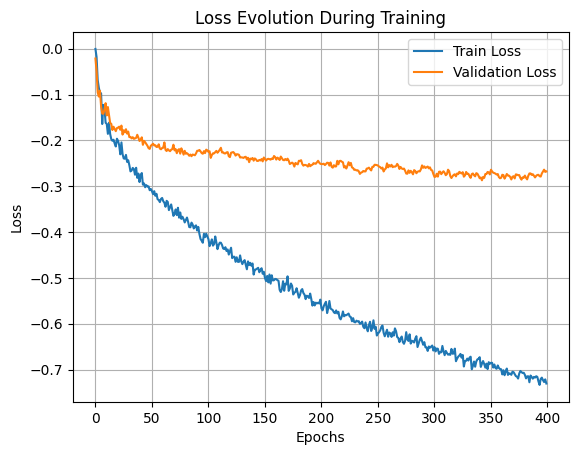

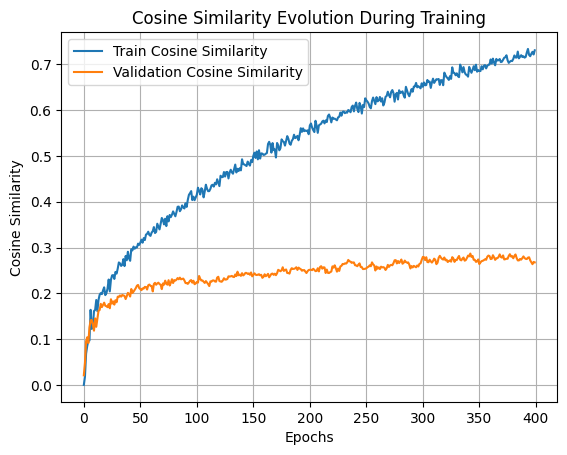

In [13]:
# Train model
history_without_orientation = model_without_orientation.fit(
    X_train_scaled, y_train,
    epochs=400,
    batch_size=16,
    validation_data=(X_test_scaled, y_test)
)
model_without_orientation_path = "model_without_orientation.h5"
# Save the trained model
model_without_orientation.save(model_without_orientation_path)
print(f"Model trained and saved as {model_without_orientation_path}")

evaluate_model_and_plot_accurracy(model_without_orientation, history_without_orientation, X_test_scaled, y_test)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,403 (3.83 MB)

 Trainable params: 334,467 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 668,936 (2.55 MB)